# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [8]:
import tensorflow as tf
import os

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [11]:
import cv2
import imghdr

In [12]:
data_dir = '/Users/kumareshjayaraman/Downloads/ImageClassification-main/data' 

In [13]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [14]:

def process_images(directory):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            # If the item is a directory, recursively process its contents
            process_images(item_path)
        else:
            # If the item is a file, check if it's an image and process it
            try:
                img = cv2.imread(item_path)
                tip = imghdr.what(item_path)
                if tip not in image_exts:
                    print('Image not in ext list {}'.format(item_path))
                    os.remove(item_path)
            except Exception as e:
                print('Issue with image {}'.format(item_path))

# 3. Load Data

In [15]:
import numpy as np
from matplotlib import pyplot as plt

In [16]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 3 classes.
Metal device set to: Apple M1


In [17]:
data_iterator = data.as_numpy_iterator()

In [18]:
batch = data_iterator.next()

2023-04-20 12:31:39.036299: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


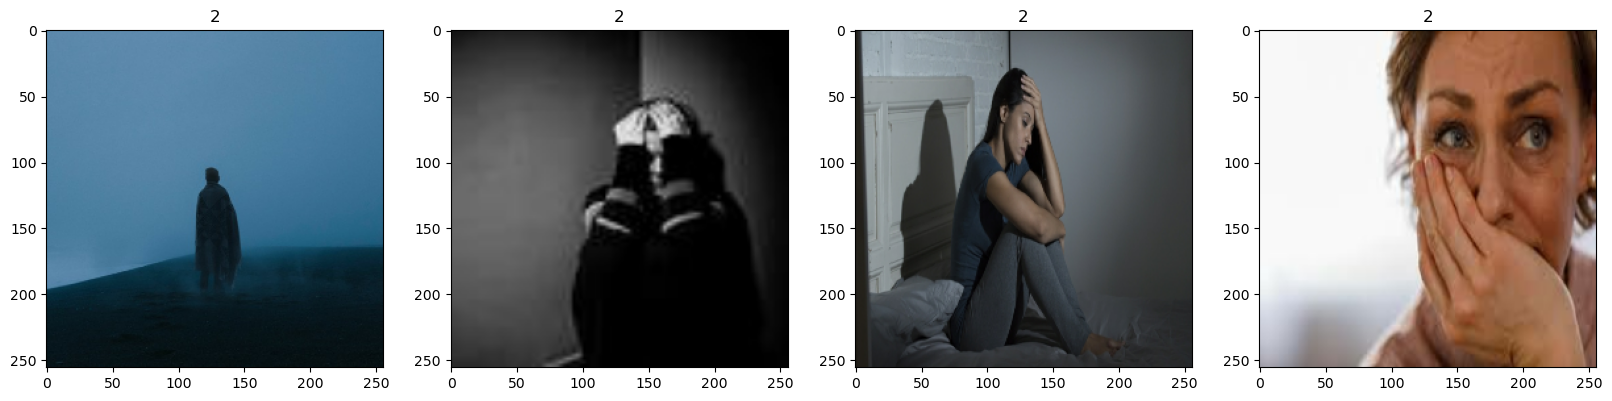

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [20]:
data = data.map(lambda x,y: (x/255, y))

In [21]:
data.as_numpy_iterator().next()

(array([[[[0.26621476, 0.35641083, 0.03574602],
          [0.2600337 , 0.3488741 , 0.04463848],
          [0.24586397, 0.329879  , 0.05716146],
          ...,
          [0.92395836, 0.958655  , 0.7239583 ],
          [0.9033165 , 0.94509804, 0.693053  ],
          [0.9019608 , 0.94509804, 0.6793352 ]],
 
         [[0.26469678, 0.35489288, 0.03765941],
          [0.2600337 , 0.3488741 , 0.04688362],
          [0.24586397, 0.329879  , 0.05716146],
          ...,
          [0.9264012 , 0.9610979 , 0.72837824],
          [0.9078704 , 0.9485294 , 0.6998521 ],
          [0.9055899 , 0.9485294 , 0.68639565]],
 
         [[0.2625    , 0.35266784, 0.04036458],
          [0.2597886 , 0.3484686 , 0.04993059],
          [0.2457601 , 0.3297751 , 0.05716146],
          ...,
          [0.9300987 , 0.9646542 , 0.735004  ],
          [0.91454554, 0.9537612 , 0.70981926],
          [0.911208  , 0.95367646, 0.6969157 ]],
 
         ...,
 
         [[0.56426406, 0.69048953, 0.4431856 ],
          [0.55176

# 5. Split Data

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [23]:
train_size

7

In [24]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [25]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [27]:
model = Sequential()

In [28]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [56]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 4s 365ms/step - loss: -12749486080.0000 - accuracy: 0.5223 - val_loss: -13858915328.0000 - val_accuracy: 0.5312
Epoch 2/20
7/7 [==============================] - 4s 362ms/step - loss: -15472266240.0000 - accuracy: 0.4955 - val_loss: -19211892736.0000 - val_accuracy: 0.4688
Epoch 3/20
7/7 [==============================] - 4s 357ms/step - loss: -19033004032.0000 - accuracy: 0.5045 - val_loss: -20418756608.0000 - val_accuracy: 0.5000
Epoch 4/20
7/7 [==============================] - 4s 359ms/step - loss: -21397149696.0000 - accuracy: 0.5223 - val_loss: -22310752256.0000 - val_accuracy: 0.5312
Epoch 5/20
7/7 [==============================] - 4s 354ms/step - loss: -26762031104.0000 - accuracy: 0.5045 - val_loss: -27635503104.0000 - val_accuracy: 0.5000
Epoch 6/20
7/7 [==============================] - 4s 358ms/step - loss: -29925425152.0000 - accuracy: 0.5312 - val_loss: -37964587008.0000 - val_accuracy: 0.4844
Epoch 7/20
7/7 [============

# 8. Plot Performance

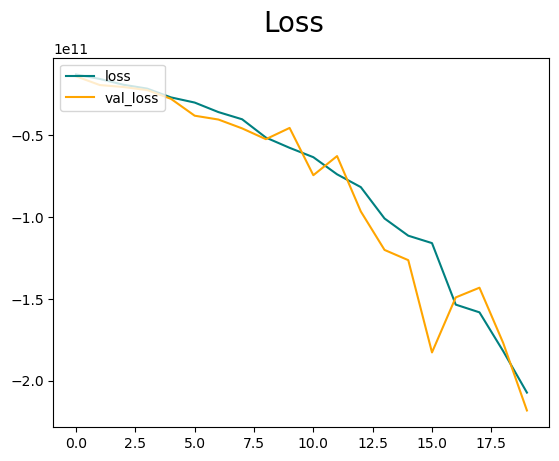

In [57]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

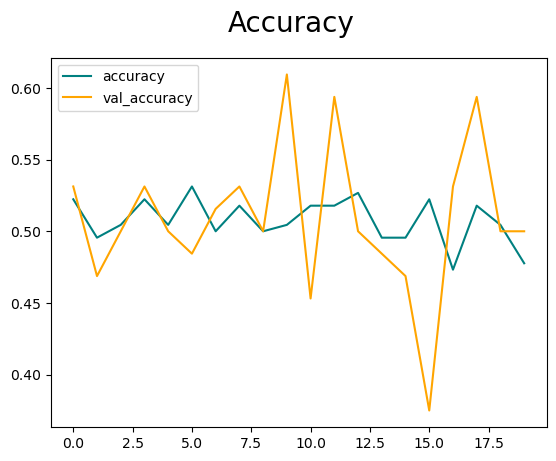

In [58]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [59]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [60]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [61]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 17ms/step


In [62]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.47058824, shape=(), dtype=float32)


# 10. Test

In [63]:
import cv2

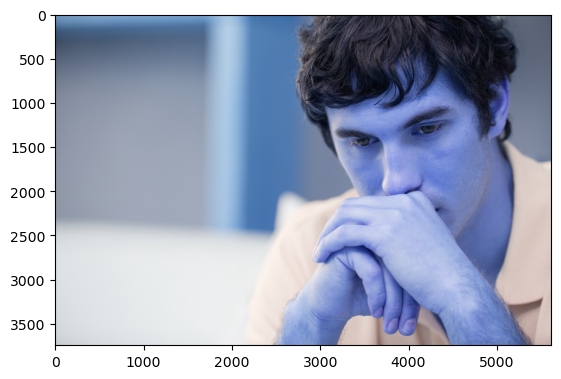

In [73]:
img = cv2.imread('8iAb9k4aT.jpg')
plt.imshow(img)
plt.show()

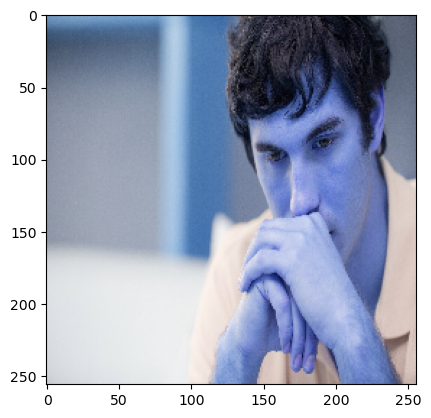

In [74]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [75]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 26ms/step


In [76]:
yhat

array([[1.]], dtype=float32)

In [77]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [69]:
from tensorflow.keras.models import load_model

In [78]:
model.save(os.path.join('models','imageclassifier6.h5'))

In [80]:
new_model = load_model('imageclassifier6.h5')

OSError: No file or directory found at imageclassifier6.h5

In [72]:
new_model.predict(np.expand_dims(resize/255, 0))

NameError: name 'new_model' is not defined